In [235]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [236]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

# By country of citizenship

Define target nationality, check if represented in dataset.

In [237]:
nationality = 'MEXICO'

In [238]:
errormsg = f'{nationality} not represented in dataset'
assert nationality.upper() in df['CountryOfCitizenship'].str.upper().unique(), errormsg

Create DataFrames for removals and transfers, removing duplicate `AlienMasterID` values.

In [239]:
removal_df = df[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')
transfer_df = df[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')

Ranking total removals by `CountryOfCitizenship`. Should implement other comparative statistics.

In [240]:
all_nationalities = removal_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique()
all_nationalities = all_nationalities.sort_values(ascending=False)
all_nationalities = all_nationalities.reset_index().reset_index()
all_nationalities['Rank'] = all_nationalities['index'] + 1
all_nationalities.drop('index', axis=1, inplace=True)
target = all_nationalities.loc[all_nationalities['CountryOfCitizenship'] == nationality]
print(f"{nationality}: ranked {target['Rank'][0]} of {len(all_nationalities)} countries, with {target['AlienMasterID'][0]} total removals.")
# Probably a better way to do this than with index

MEXICO: ranked 1 of 209 countries, with 466455 total removals.


Create a DataFrame filtered for target nationality only.

In [241]:
nationality_df = df[df['CountryOfCitizenship'] == nationality.upper()]

In [242]:
# Top pickup airports (removals and transfers)
nationality_df['air_AirportName'].value_counts().head(10)

El Paso International Airport                     90303
Valley International Airport                      86152
Alexandria International Airport                  57558
Columbus Metropolitan Airport                     49389
Metropolitan Oakland International Airport        32938
Harrisburg International Airport                  28315
Boeing Field King County International Airport    25156
San Diego International Airport                   23543
Meadows Field                                     20494
Miami International Airport                       20042
Name: air_AirportName, dtype: int64

In [243]:
# Top dropoff airports (removals and transfers)
nationality_df['air2_AirportName'].value_counts().head(10)

Valley International Airport                            146867
Licenciado Benito Juarez International Airport           85584
El Paso International Airport                            65239
Brownsville South Padre Island International Airport     63458
San Diego International Airport                          59678
Yuma MCAS/Yuma International Airport                     58120
Laredo International Airport                             46149
El Centro Naf Airport                                    20356
Phoenix-Mesa-Gateway Airport                             18186
Alexandria International Airport                         16249
Name: air2_AirportName, dtype: int64

In [244]:
nationality_df.set_index('MissionDate', inplace=True)

In [245]:
g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])

In [246]:
# We can improve construction of this table, look at other notebooks
table = g['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = g['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']
table['JuvenileCount'] = g['Juvenile'].sum().reset_index(name='JuvenileCount')['JuvenileCount']
table['JuvPercent'] = table['JuvenileCount'] / table['AlienMasterIDCount']
table['NCCount'] = g['NonCriminal'].sum().reset_index(name='NCCount')['NCCount']
table['NCPercent'] = table['NCCount'] / table['AlienMasterIDCount'] * 100

In [247]:
removals = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [248]:
removals.set_index('MissionDate', inplace=True)
transfers.set_index('MissionDate', inplace=True)

In [249]:
# Total removals
removals['AlienMasterIDCount'].sum()

466107

In [250]:
# Total removal missions
removals['MissionIDCount'].sum()

10164

In [251]:
# Total transfers
transfers['AlienMasterIDCount'].sum()

101514

In [252]:
weekly_removals = removals['AlienMasterIDCount'].resample('W').sum()
weekly_transfers = transfers['AlienMasterIDCount'].resample('W').sum()
monthly_removals = removals['AlienMasterIDCount'].resample('M').sum()
monthly_transfers = transfers['AlienMasterIDCount'].resample('M').sum()
monthly_removal_flights = removals['MissionIDCount'].resample('M').sum()
monthly_transfers_flights = transfers['MissionIDCount'].resample('M').sum()
annual_removals = removals['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_transfers = transfers['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_removal_flights = removals['MissionIDCount'].resample('AS-OCT').sum()
annual_transfer_flights = transfers['MissionIDCount'].resample('AS-OCT').sum()
annual_juvenile_removals = removals['JuvenileCount'].resample('AS-OCT').sum()

In [253]:
annual_removals

MissionDate
2010-10-01    107781
2011-10-01    110763
2012-10-01     78650
2013-10-01     39278
2014-10-01     29461
2015-10-01     27082
2016-10-01     32967
2017-10-01     34738
2018-10-01      5387
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [254]:
annual_transfers

MissionDate
2010-10-01     8947
2011-10-01     9445
2012-10-01     8368
2013-10-01    12185
2014-10-01    16048
2015-10-01    19730
2016-10-01    13896
2017-10-01    12365
2018-10-01      530
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [255]:
annual_juvenile_removals

MissionDate
2010-10-01    432.0
2011-10-01     55.0
2012-10-01     19.0
2013-10-01     11.0
2014-10-01     27.0
2015-10-01     19.0
2016-10-01      0.0
2017-10-01      5.0
2018-10-01      0.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [256]:
removals.reset_index(inplace=True, drop=False)
transfers.reset_index(inplace=True, drop=False)

In [257]:
removals.tail(20)

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
10116,2018-11-28,MEXICO,R,KMSP,KBRO,15,1,0.0,0.0,1.0,6.666667
10117,2018-11-28,MEXICO,R,KOMA,KBRO,12,1,0.0,0.0,4.0,33.333333
10118,2018-11-29,MEXICO,R,KAEX,KBRO,1,1,0.0,0.0,1.0,100.000000
10119,2018-11-29,MEXICO,R,KATL,KBRO,56,1,0.0,0.0,10.0,17.857143
10120,2018-11-29,MEXICO,R,KMIA,KBRO,38,1,0.0,0.0,11.0,28.947368
10121,2018-11-30,MEXICO,R,KSLC,KELP,6,1,0.0,0.0,2.0,33.333333
10122,2018-11-30,MEXICO,R,KCOS,KELP,33,1,0.0,0.0,9.0,27.272727
10123,2018-11-30,MEXICO,R,KGYY,KBRO,45,1,0.0,0.0,6.0,13.333333
10124,2018-12-03,MEXICO,R,KAEX,KBRO,58,1,0.0,0.0,16.0,27.586207
10125,2018-12-03,MEXICO,R,KATL,KBRO,71,1,0.0,0.0,14.0,19.718310


In [258]:
removals.to_csv(f'../output/{nationality}_removal_flights.csv')

In [259]:
transfers.head()

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
0,2010-10-01,MEXICO,T,KBFL,KIWA,3,1,1.0,0.333333,0.0,0.0
1,2010-10-01,MEXICO,T,KBFL,KSAN,7,1,0.0,0.000000,0.0,0.0
2,2010-10-01,MEXICO,T,KMDT,KAEX,20,1,0.0,0.000000,0.0,0.0
3,2010-10-01,MEXICO,T,KOAK,KIWA,4,1,0.0,0.000000,0.0,0.0
4,2010-10-01,MEXICO,T,KOAK,KSAN,2,1,0.0,0.000000,0.0,0.0


In [260]:
# transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
# removals.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [261]:
removals.set_index('MissionDate', inplace=True)

In [262]:
transfers.set_index('MissionDate', inplace=True)

In [263]:
r_cum = removals['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

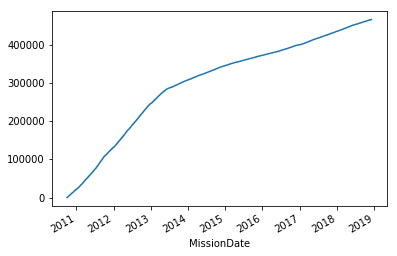

In [264]:
# Cumulative removals
# Based on density of removals, decide whether to use points or line
# r_cum.plot(style='o-')
r_cum.plot(style='-')

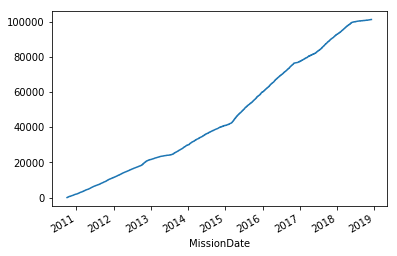

In [265]:
# Cumulative transfers
t_cum.plot()

In [266]:
g = nationality_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'air_AirportName', 'air2_AirportName', 'air2_Country'])[['AlienMasterID', 'MissionID']].nunique()
g.reset_index(inplace=True)
removal_dropoff_airports = g[g['R-T'] == 'R'].copy()
transfer_dropoff_airports = g[g['R-T'] == 'T'].copy()

In [267]:
removal_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)
transfer_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)

In [268]:
removal_dropoff_airports.head()

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
76,2010-10-01,R,Tucson International Airport,Licenciado Benito Juarez International Airport,Mexico,8665,77
39,2010-10-01,R,Metropolitan Oakland International Airport,San Diego International Airport,USA,8457,224
2,2010-10-01,R,Alexandria International Airport,Valley International Airport,USA,8425,95
18,2010-10-01,R,El Paso International Airport,Valley International Airport,USA,7475,171
23,2010-10-01,R,Harrisburg International Airport,Valley International Airport,USA,6790,82


In [269]:
transfer_dropoff_airports.head(10)

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
124,2010-10-01,T,Metropolitan Oakland International Airport,Phoenix-Mesa-Gateway Airport,USA,1621,217
117,2010-10-01,T,Meadows Field,Phoenix-Mesa-Gateway Airport,USA,1370,209
159,2010-10-01,T,San Diego International Airport,El Paso International Airport,USA,1172,91
100,2010-10-01,T,Harrisburg International Airport,Alexandria International Airport,USA,373,27
125,2010-10-01,T,Metropolitan Oakland International Airport,San Diego International Airport,USA,311,62
101,2010-10-01,T,Harrisburg International Airport,El Paso International Airport,USA,294,18
161,2010-10-01,T,San Diego International Airport,Phoenix-Mesa-Gateway Airport,USA,279,73
175,2010-10-01,T,Boise Air Terminal/Gowen field,Salt Lake City International Airport,USA,242,25
150,2010-10-01,T,Reno Tahoe International Airport,Phoenix-Mesa-Gateway Airport,USA,229,39
135,2010-10-01,T,Phoenix-Mesa-Gateway Airport,Boeing Field King County International Airport,USA,227,29


In [270]:
# removal_dropoff_airports.to_csv(f'../output/{nationality}_repatriation_dropoff_airports.csv')
# transfer_dropoff_airports.to_csv(f'../output/{nationality}_transfer_dropoff_airports.csv')

In [271]:
removal_dropoff_airports = removal_dropoff_airports.set_index('MissionDate')

In [272]:
removal_sum = removal_dropoff_airports.groupby([pd.Grouper(freq='AS-OCT'), 'air2_AirportName'])[['AlienMasterID']].sum()

In [273]:
removal_sum.reset_index(inplace=True)
removal_sum = removal_sum.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False])

In [274]:
removal_sum.set_index('MissionDate', inplace=True)

In [275]:
removal_sum = removal_sum.dropna()

In [276]:
top_5_df = pd.DataFrame()

for year in removal_sum.index.unique():
    temp = removal_sum.loc[f'{year}'][['air2_AirportName', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['air2_AirportName', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

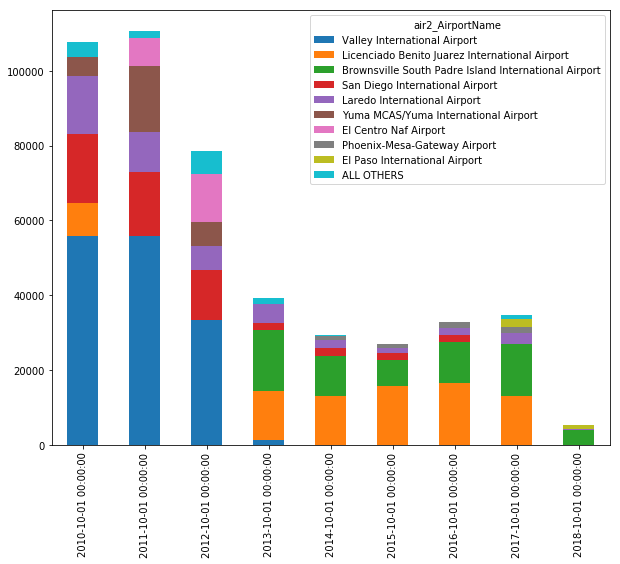

In [277]:
pivot = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='air2_AirportName',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)
cols = list(pivot.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
pivot = pivot[cols]

fig = pivot.plot(kind='bar', stacked=True, figsize=(10, 8))

## Juveniles only

In [278]:
juv_r_cum = removals['JuvenileCount'].cumsum()

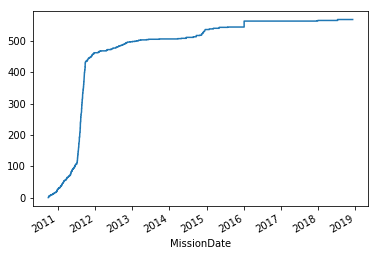

In [279]:
juv_r_cum.plot()

In [280]:
removals.tail(20)

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2018-11-28,MEXICO,R,KMSP,KBRO,15,1,0.0,0.0,1.0,6.666667
2018-11-28,MEXICO,R,KOMA,KBRO,12,1,0.0,0.0,4.0,33.333333
2018-11-29,MEXICO,R,KAEX,KBRO,1,1,0.0,0.0,1.0,100.000000
2018-11-29,MEXICO,R,KATL,KBRO,56,1,0.0,0.0,10.0,17.857143
2018-11-29,MEXICO,R,KMIA,KBRO,38,1,0.0,0.0,11.0,28.947368
2018-11-30,MEXICO,R,KSLC,KELP,6,1,0.0,0.0,2.0,33.333333
2018-11-30,MEXICO,R,KCOS,KELP,33,1,0.0,0.0,9.0,27.272727
2018-11-30,MEXICO,R,KGYY,KBRO,45,1,0.0,0.0,6.0,13.333333
2018-12-03,MEXICO,R,KAEX,KBRO,58,1,0.0,0.0,16.0,27.586207


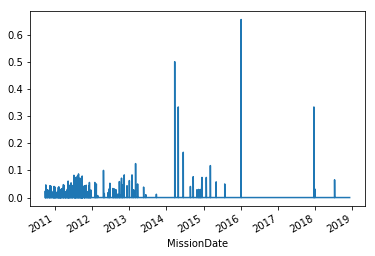

In [281]:
removals['JuvPercent'].plot();

In [282]:
removals['JuvCount'].plot();

KeyError: 'JuvCount'

In [ ]:
removals[removals['JuvPercent'] > .5]

In [ ]:
transfers['JuvenileCount'].value_counts()

In [ ]:
removals[removals['JuvenileCount'] > 20]

# KBFI only

In [ ]:
airport = 'KBFI'

In [ ]:
airport_removals = pd.concat([removals[removals['PULOC'] == airport], removals[removals['DropLoc'] == airport]])

In [ ]:
airport_removals

In [ ]:
airport_transfers = pd.concat([transfers[transfers['PULOC'] == airport], transfers[transfers['DropLoc'] == airport]])

In [ ]:
airport_transfers.to_csv(f'../output/{nationality}_transfers_tofrom_{airport}.csv')

In [ ]:
airport_weekly_removals = airport_removals['AlienMasterIDCount'].resample('W').nunique()
airport_weekly_transfers = airport_transfers['AlienMasterIDCount'].resample('W').nunique()
airport_monthly_removals = airport_removals['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_transfers = airport_transfers['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_removal_flights = airport_removals['MissionIDCount'].resample('M').nunique()
airport_monthly_transfers_flights = airport_transfers['MissionIDCount'].resample('M').nunique()
airport_annual_removals = airport_removals['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_transfers = airport_transfers['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_removal_flights = airport_removals['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_transfer_flights = airport_transfers['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_juvenile_removals = airport_removals['JuvenileCount'].resample('AS-OCT').sum()
airport_annual_juvenile_transfers = airport_transfers['JuvenileCount'].resample('AS-OCT').sum()

In [ ]:
airport_annual_removals

In [ ]:
airport_annual_removal_flights

In [ ]:
airport_annual_juvenile_removals

In [ ]:
airport_annual_transfers

In [ ]:
airport_annual_transfer_flights

In [ ]:
airport_annual_juvenile_transfers

# Criminal status

 `Criminality` is not fully consistent with `Convictions`; especially in FY2010. 

In [ ]:
removals['NCPercent']

In [ ]:
removals['NCCount'].resample('AS-OCT').sum()

In [ ]:
removals['AlienMasterIDCount'].resample('AS-OCT').sum()